In [1]:
!pip install category_encoders --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
project_path = '/content/drive/My Drive/data-mining/model/'
if project_path not in sys.path:
    sys.path.append(project_path)
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/data-mining/model/']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from my_pytorch_utils.pytorch_model import PyTorchRegressorWrapper
import xgboost as xgb
import time  # To time the tuning process
from sklearn.inspection import permutation_importance
import warnings

In [5]:
df_train = pd.read_csv('/content/drive/My Drive/data-mining/train_data/train_data_preprocessed.csv')
df_test = pd.read_csv('/content/drive/My Drive/data-mining/train_data//test_data_preprocessed.csv')

In [6]:
len(df_train)

329020

In [7]:
df_train.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [8]:
df_train.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [9]:
df_train.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [10]:
# Make a copy for EDA to avoid altering the original df_train used for modeling pipeline
df_eda = df_train.copy()

In [11]:
# Define numerical and categorical columns based on your dataset inspection and modeling choices
# Note: 'price' is the target, 'year' and 'odometer' are numerical predictors.
numerical_eda_cols = ['price', 'year', 'odometer']
categorical_eda_cols = ['cylinders', 'manufacturer', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color']
# 'region', 'state', 'model' are very high cardinality, requires special handling (e.g., top N, aggregation)


--- 1. Numerical Feature Correlation ---


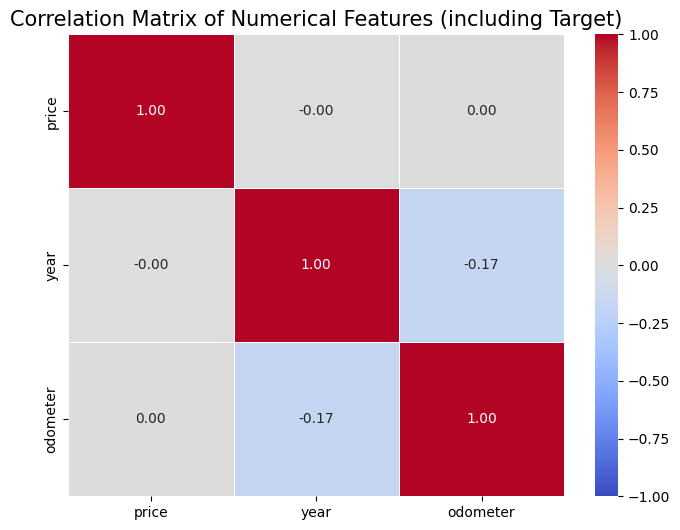


Observations from numerical correlation:
- Price and Year: Positive correlation (newer cars tend to be more expensive).
- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).
- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).



In [12]:
# 1. Numerical Feature Correlation
print("--- 1. Numerical Feature Correlation ---")
plt.figure(figsize=(8, 6))
numerical_corr = df_eda[numerical_eda_cols].corr()
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features (including Target)", fontsize=15)
plt.show()
print("\nObservations from numerical correlation:")
print("- Price and Year: Positive correlation (newer cars tend to be more expensive).")
print("- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).")
print("- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).\n")


<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


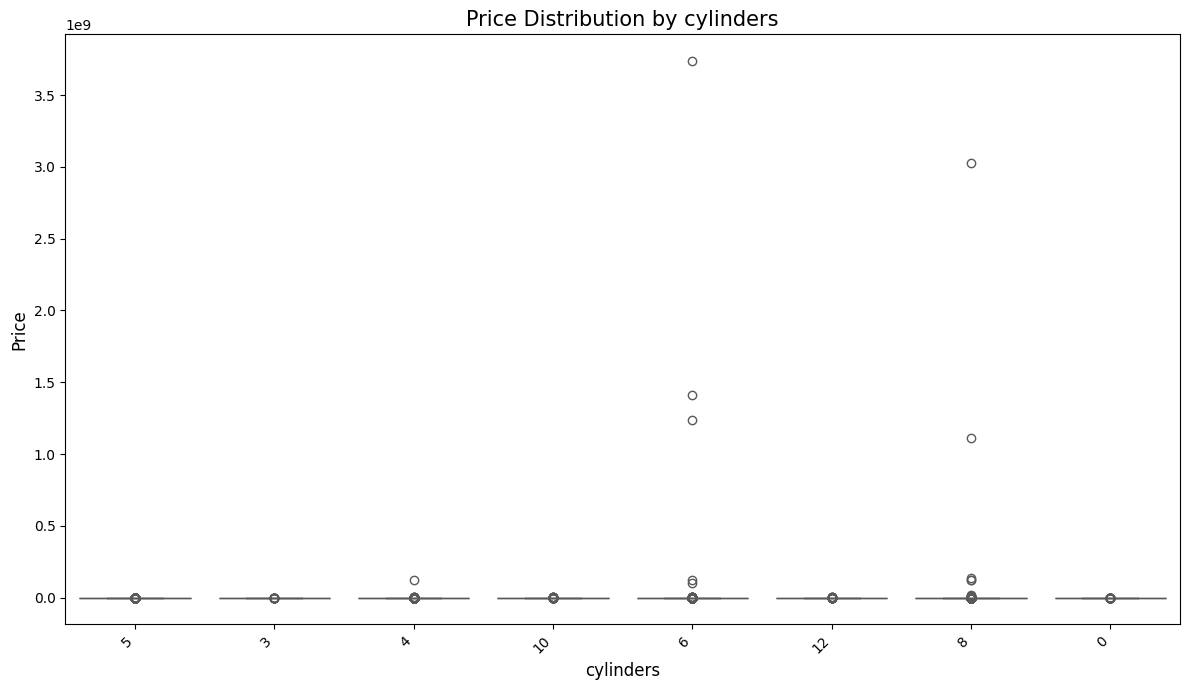

Median price by cylinders:
cylinders
0     24990.0
8     19999.0
12    17925.0
6     14999.0
10    12999.0
4      9999.0
3      8990.0
5      6854.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


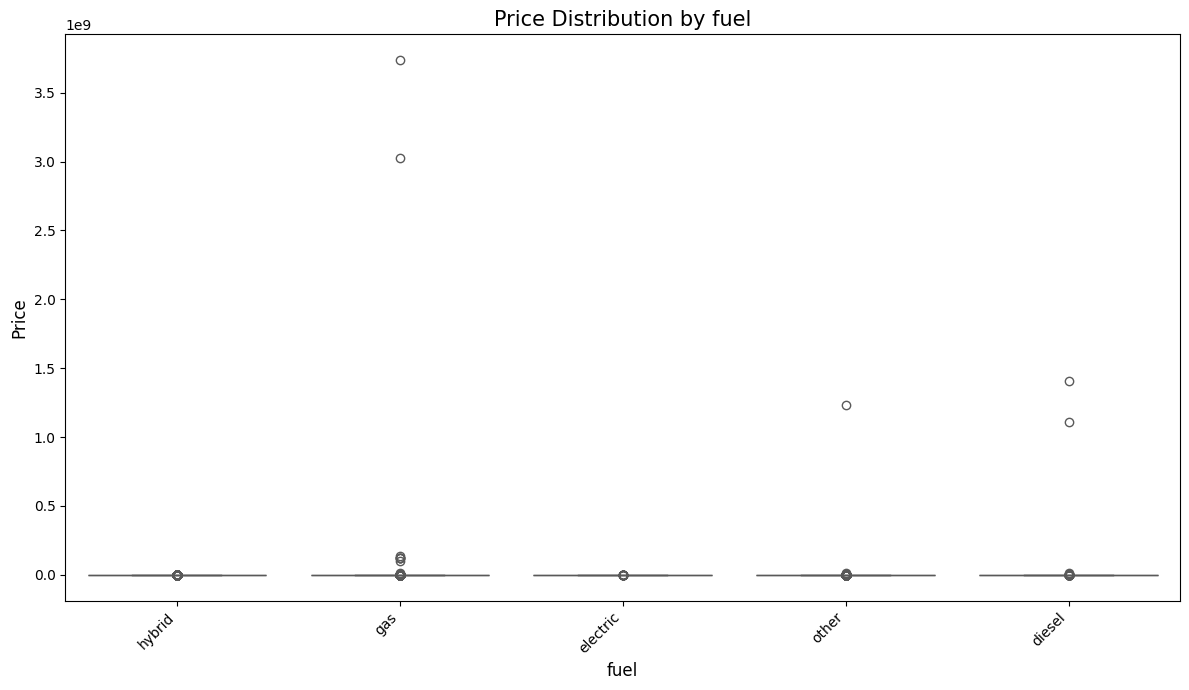

Median price by fuel:
fuel
diesel      28900.0
other       25990.0
electric    22995.0
gas         12280.0
hybrid      11995.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


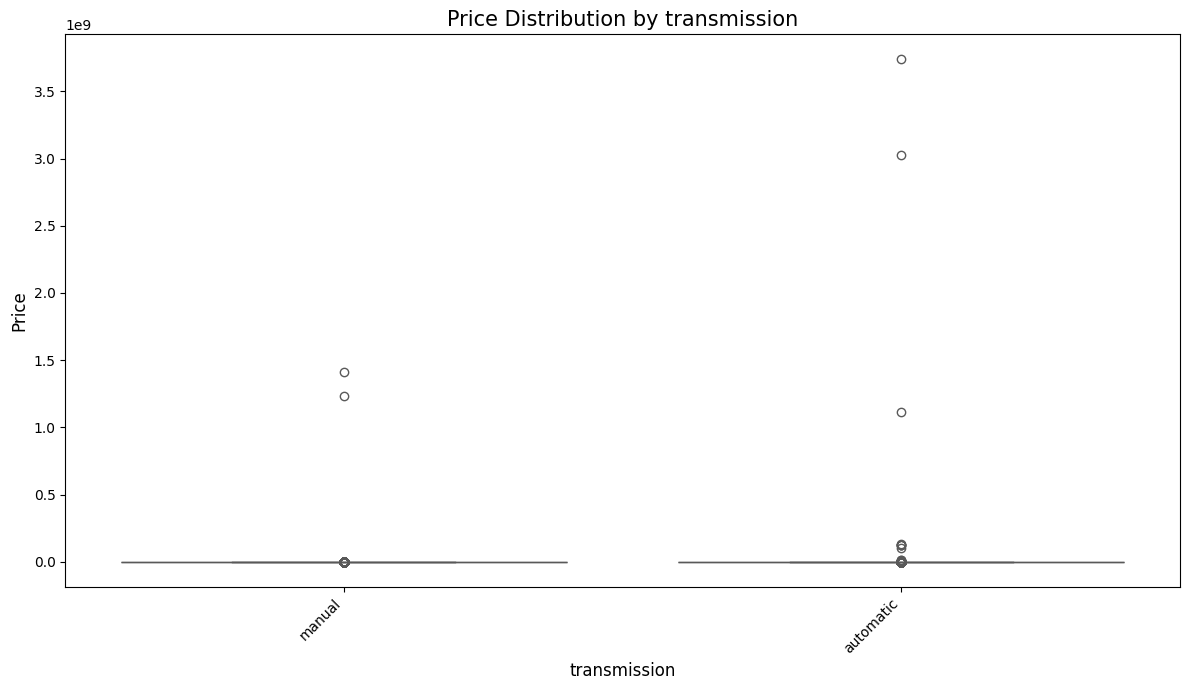

Median price by transmission:
transmission
automatic    14481.0
manual        9323.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


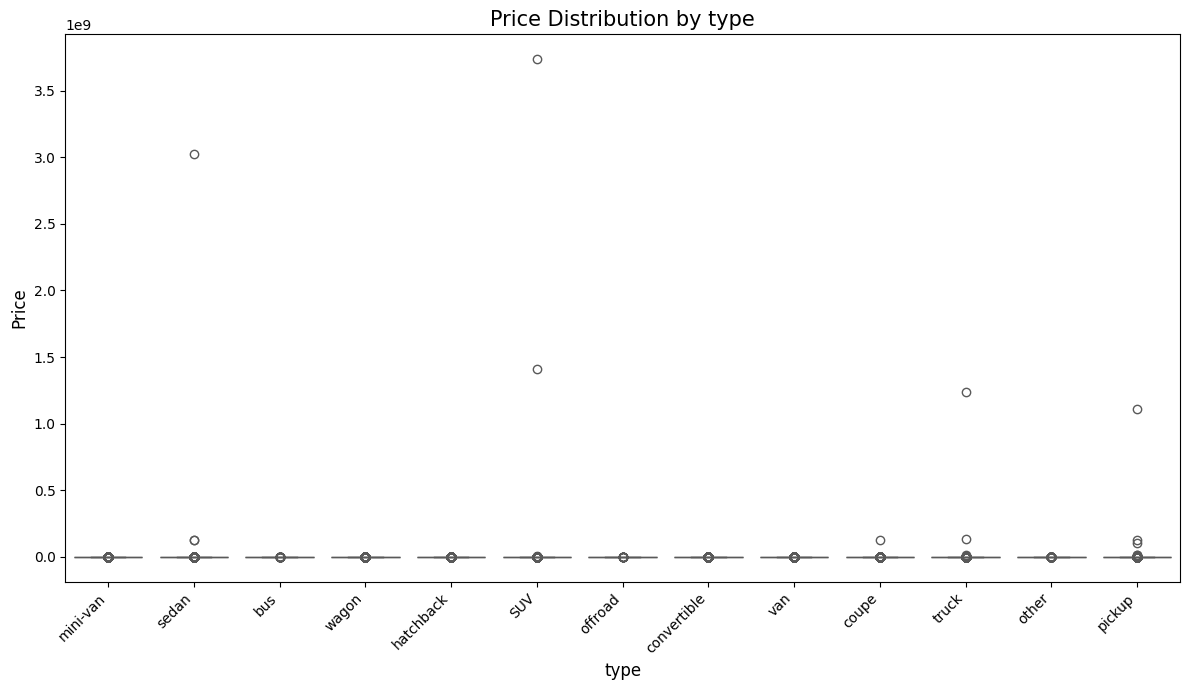

Median price by type:
type
pickup         26590.0
other          25990.0
truck          21995.0
coupe          17500.0
van            14995.0
convertible    14500.0
offroad        12500.0
SUV            12499.0
hatchback      11995.0
wagon          11152.0
bus             9500.0
sedan           8995.0
mini-van        6500.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


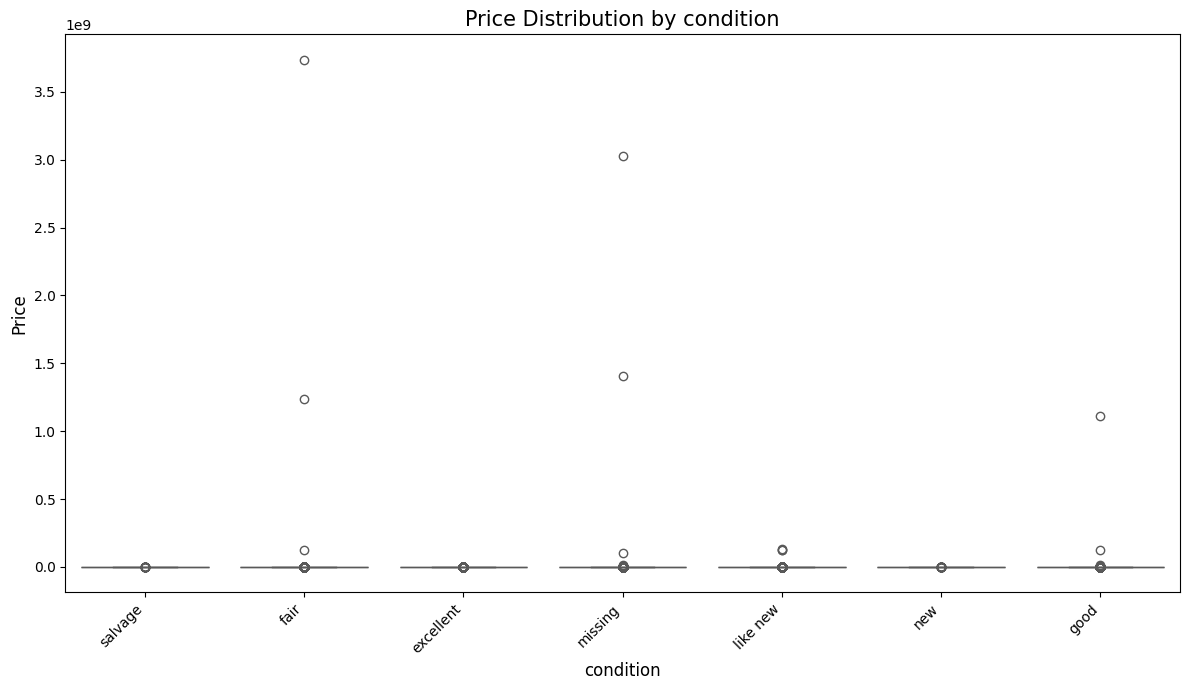

Median price by condition:
condition
good         20590.0
new          15999.0
like new     13995.0
missing      12999.0
excellent    10995.0
fair          2750.0
salvage       1845.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


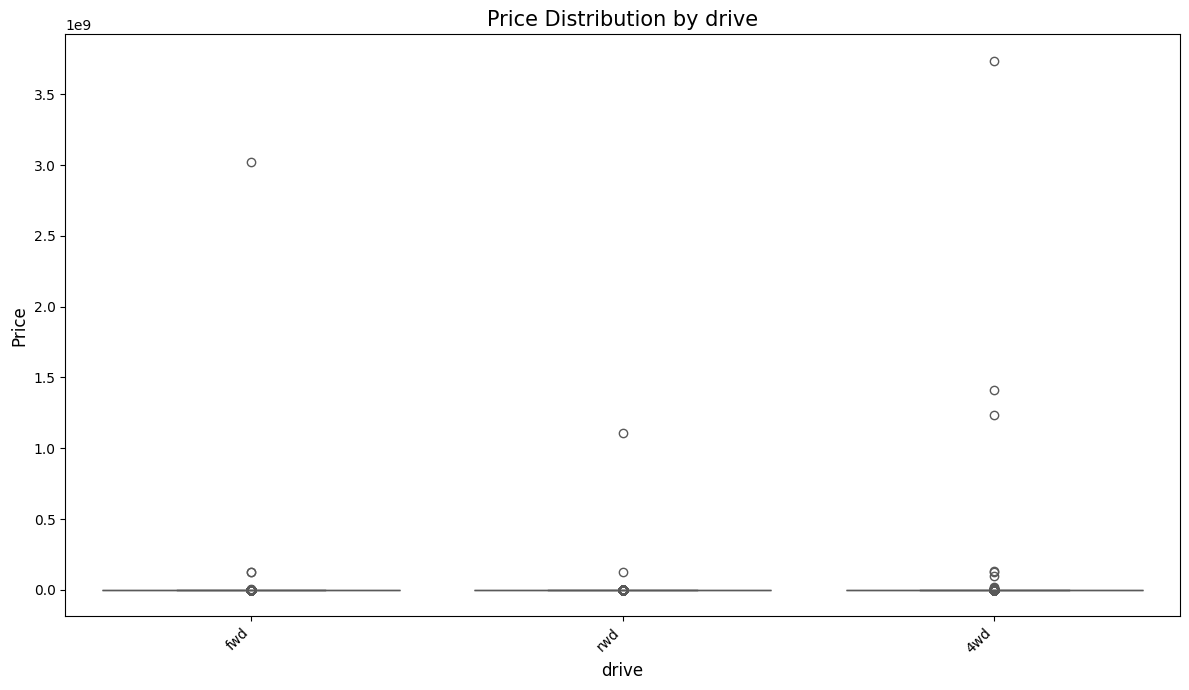

Median price by drive:
drive
4wd    18163.5
rwd    17495.0
fwd     9000.0
Name: price, dtype: float64



<ipython-input-13-b9649fb11033>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


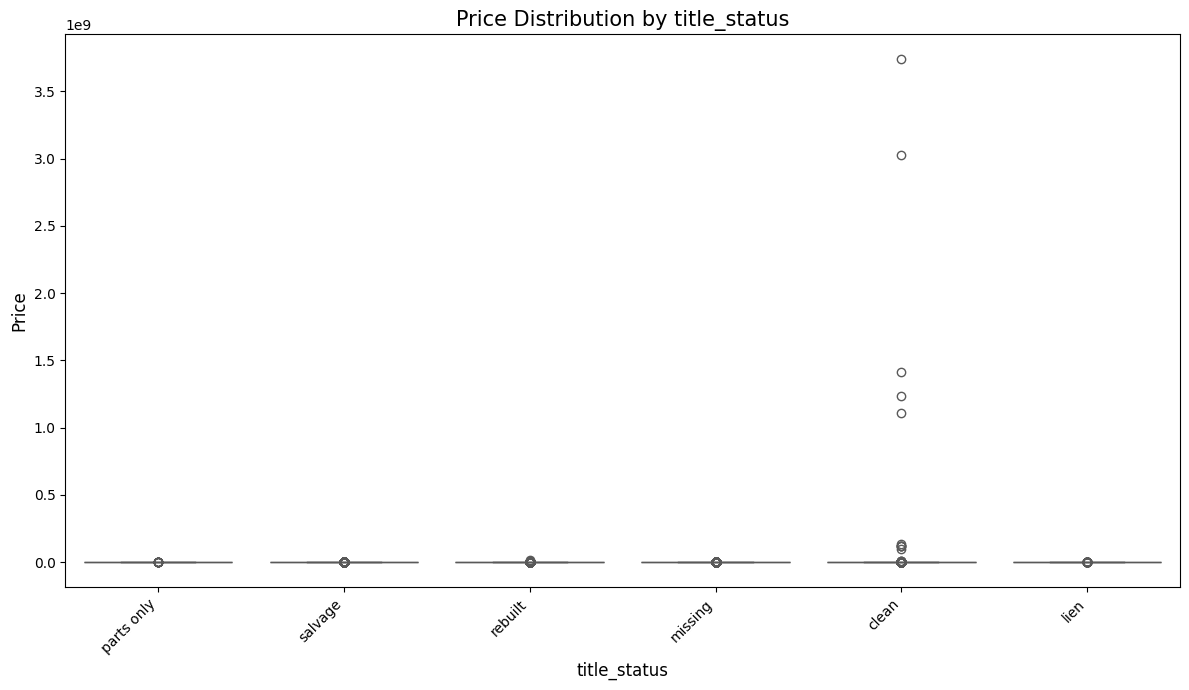

Median price by title_status:
title_status
lien          17500.0
clean         14470.0
missing       10426.5
rebuilt       10000.0
salvage        7500.0
parts only     1200.0
Name: price, dtype: float64


--- Example: Price by Top N Manufacturers ---


<ipython-input-13-b9649fb11033>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")


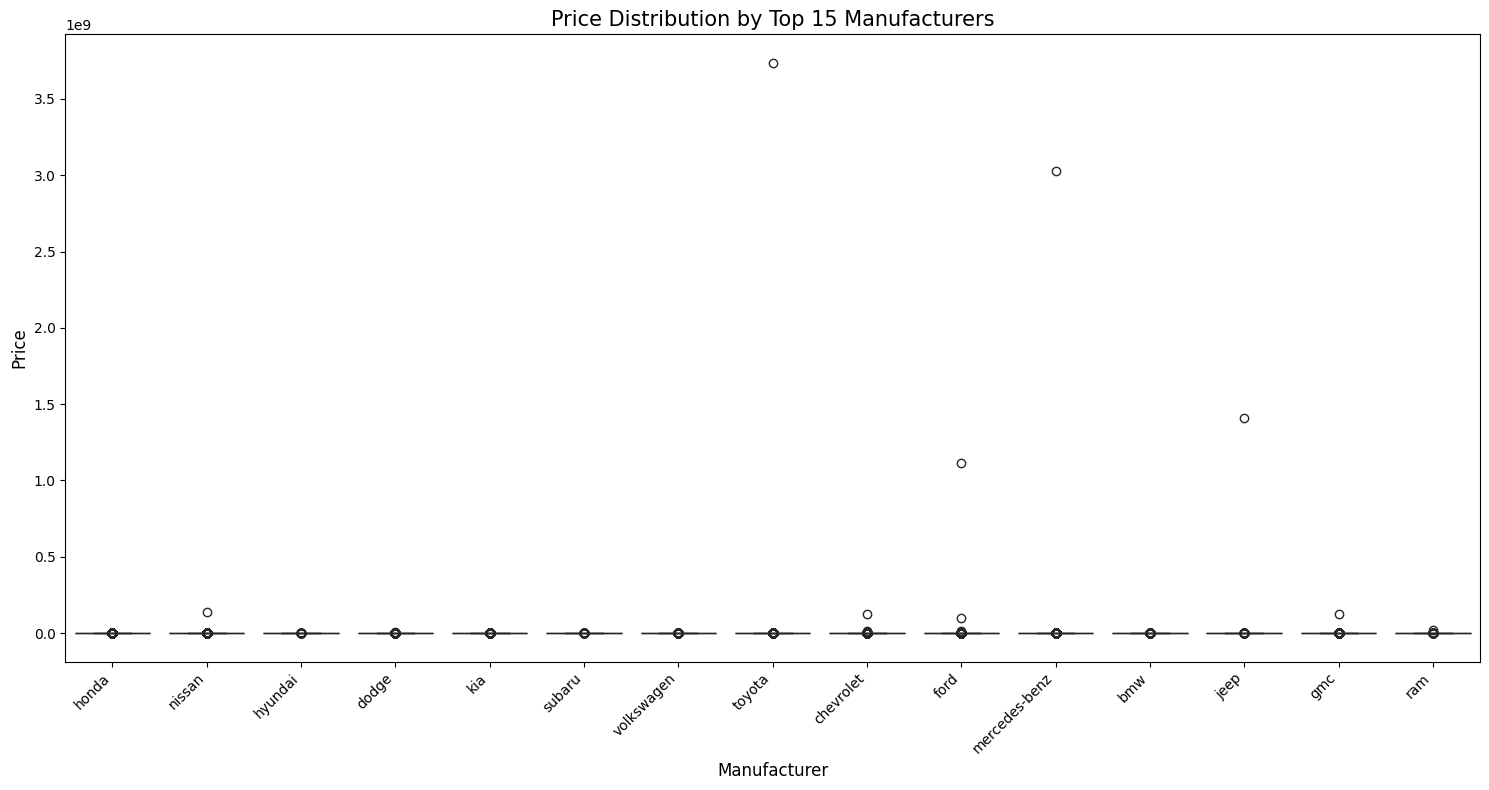

Median price by Top 15 Manufacturers (sorted by median price):
manufacturer
ram              28000.0
gmc              21637.0
jeep             16900.0
bmw              16790.0
mercedes-benz    15950.0
ford             15376.0
chevrolet        14833.0
toyota           12000.0
volkswagen       10995.0
subaru           10991.0
kia              10572.0
dodge             9892.5
hyundai           9876.0
nissan            9400.0
honda             8590.0
Name: price, dtype: float64



In [13]:
# 2. Categorical Features vs. Target (Price)
# Select a subset of categorical features for detailed plotting to avoid clutter
# Features with low to moderate cardinality are good candidates
cat_cols_for_price_boxplot = ['cylinders', 'fuel', 'transmission', 'type', 'condition', 'drive', 'title_status']

for col in cat_cols_for_price_boxplot:

    # To make boxplots more readable, order categories by median price
    order = df_eda.groupby(col)['price'].median().sort_values().index

    plt.figure(figsize=(12, 7))
    sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")
    plt.title(f'Price Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Display median prices for reference
    print(f"Median price by {col}:\n{df_eda.groupby(col)['price'].median().sort_values(ascending=False)}\n")

# Example for a high-cardinality feature: Manufacturer (Top N by count)
print("\n--- Example: Price by Top N Manufacturers ---")
top_n = 15
top_manufacturers = df_eda['manufacturer'].value_counts().nlargest(top_n).index
df_top_manu = df_eda[df_eda['manufacturer'].isin(top_manufacturers)]

# Order by median price
manu_order = df_top_manu.groupby('manufacturer')['price'].median().sort_values().index

plt.figure(figsize=(15, 8))
sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")
plt.title(f'Price Distribution by Top {top_n} Manufacturers', fontsize=15)
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"Median price by Top {top_n} Manufacturers (sorted by median price):\n{df_top_manu.groupby('manufacturer')['price'].median().sort_values(ascending=False)}\n")


<ipython-input-14-037986db60f9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


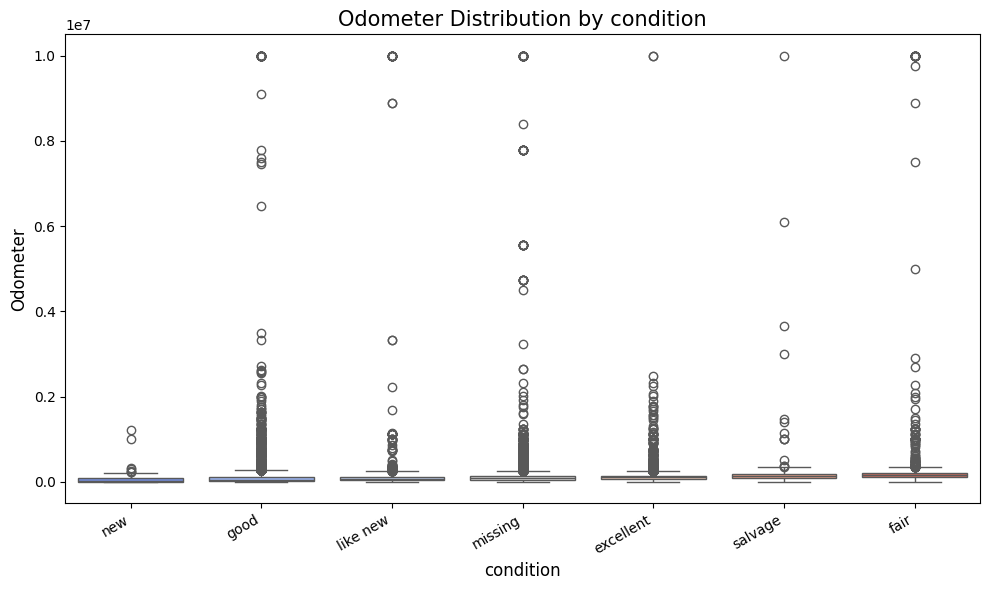

Median odometer by condition:
condition
fair         168000.0
salvage      142931.0
excellent    102485.0
missing       89000.0
like new      76067.0
good          51525.0
new            8226.0
Name: odometer, dtype: float64



<ipython-input-14-037986db60f9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


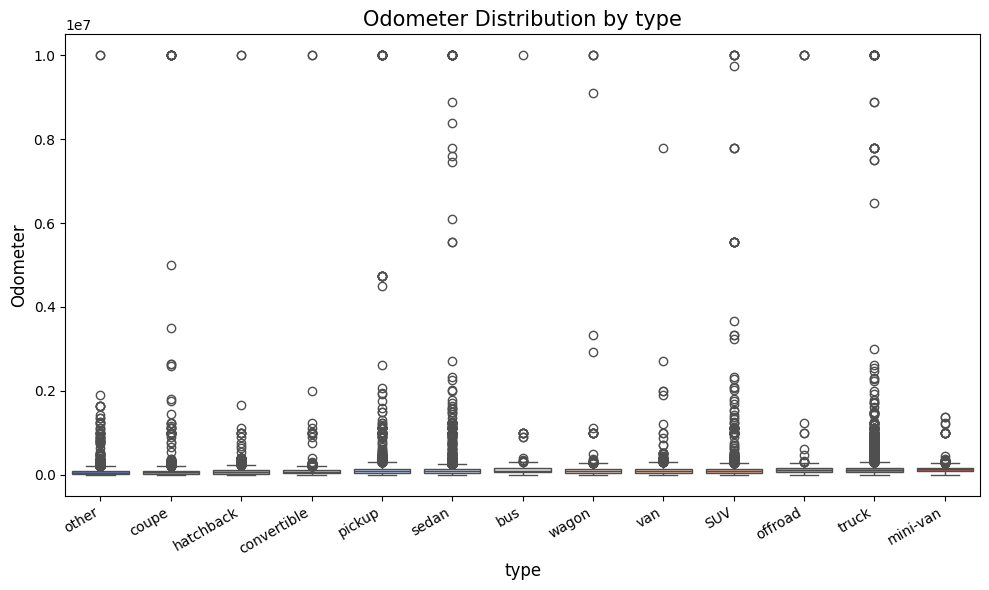

Median odometer by type:
type
mini-van       129161.0
truck          103434.0
offroad        103000.0
SUV             98000.0
van             94599.0
wagon           93593.0
bus             93000.0
sedan           86268.0
pickup          78700.0
convertible     69000.0
hatchback       61401.0
coupe           55635.0
other           40549.0
Name: odometer, dtype: float64



<ipython-input-14-037986db60f9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


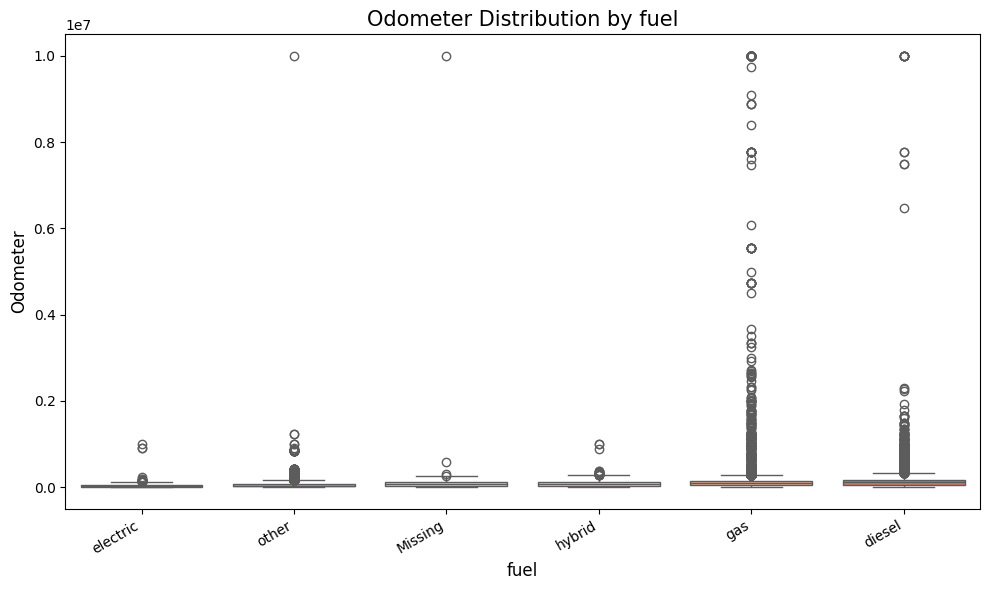

Median odometer by fuel:
fuel
diesel      110180.0
gas          89044.5
hybrid       80000.0
Missing      78699.0
other        37791.0
electric     28805.0
Name: odometer, dtype: float64



In [14]:
# 3. Categorical Features vs. Another Numerical Feature (e.g., Odometer)
cat_cols_for_odo_boxplot = ['condition', 'type', 'fuel'] # Example features

for col in cat_cols_for_odo_boxplot:
    df_eda[col] = df_eda[col].fillna('Missing') # Ensure NaNs are handled for plotting
    order = df_eda.groupby(col)['odometer'].median().sort_values().index # Order by median odometer

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")
    # Filter out extreme odometer outliers for better visualization if necessary
    # sns.boxplot(x=col, y='odometer', data=df_eda[df_eda['odometer'] < df_eda['odometer'].quantile(0.99)], order=order)
    plt.title(f'Odometer Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Odometer', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"Median odometer by {col}:\n{df_eda.groupby(col)['odometer'].median().sort_values(ascending=False)}\n")



In [15]:
X_train = df_train.drop(columns=['price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

In [16]:
!pip install pygam

In [17]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [18]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from pygam import LinearGAM

# Define columns
cat_columns = ['cylinders', 'region', 'manufacturer', 'state', 'model', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color' ]
num_columns = ['year', 'odometer']

# Create proper preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer([
    # For categorical features, split by encoding typ
    ('region_enc', Pipeline([
        ('encoder', ce.BinaryEncoder())
    ]), ['region']),

    ('freq_enc', Pipeline([
        ('encoder', ce.CountEncoder())
    ]), ['manufacturer', 'state', 'model']),

    ('onehot_enc', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), ['fuel', 'drive', 'transmission', 'type', 'title_status', 'paint_color', 'cylinders']),

    ('ordinal_enc', Pipeline([
        ('encoder', OrdinalEncoder())
    ]), ['condition', 'size']),

    # For numerical features
    ('num', Pipeline([
        ('scaler', StandardScaler())
    ]), num_columns)
], remainder='drop')


# Dictionary of regressors
model_pipelines = {
    # --- Linear Models ---
   'linear_simple': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression(n_jobs=-1),)
    ]),
    'linear_poly': Pipeline([
        ('preprocessor', preprocessor),
        ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    #'knn': Pipeline([
        #('preprocessor', preprocessor),
        #('regressor', KNeighborsRegressor(n_jobs=-1))
    #]),
    #'ridge': Pipeline([ # NEW: Simple Ridge
        #('preprocessor', preprocessor),
        #('regressor', Ridge(random_state=42)) # alpha will be tuned
   # ]),
    #'ridge_poly': Pipeline([ # NEW: Polynomial Ridge
       # ('preprocessor', preprocessor),
       # ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Ridge(random_state=42)) # alpha will be tuned
  # ]),
    #'lasso': Pipeline([ # NEW: Simple Lasso
        #('preprocessor', preprocessor),
        #('regressor', Lasso(random_state=42)) # alpha will be tuned
   # ]),
  #  #'lasso_poly': Pipeline([ # NEW: Polynomial Lasso
        #('preprocessor', preprocessor),
        #('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Lasso(random_state=42)) # alpha will be tuned
 #   ]),
    #'gam': Pipeline([ # NEW: Generalized Additive Models
       # ('preprocessor', preprocessor),
       # ('regressor', LinearGAM())
   # ]),
    #'svr': Pipeline([
      #  ('preprocessor', preprocessor),
      #  ('regressor', SVR()) # Note: SVR is computationally expensive, esp. with many features (like from poly)
  #  ]),
    'dt': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'rf': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
   # 'gb': Pipeline([ # NEW: gradBoost
    #    ('preprocessor', preprocessor),
     #   ('regressor', HistGradientBoostingRegressor(random_state=42))
   # ]),
    'xgb': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')),
    ]),
    #'pytorch_linear': Pipeline([
       # ('preprocessor', preprocessor), # Use the SAME preprocessor!
       # ('regressor', PyTorchRegressorWrapper(lr=0.01, epochs=50, batch_size=64)) # Adjust hyperparameters
   # ])
}

In [19]:
import numpy as np
from scipy.stats import loguniform, uniform, randint
from sklearn.model_selection import RandomizedSearchCV
# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    # --- Linear Models ---
    'linear_simple': {
        'regressor__fit_intercept': [True],
    },
    'linear_poly': {
        'poly_features__degree': [2], # Just test degree 2 initially
        'regressor__fit_intercept': [True],
    },
    'ridge': {
        'regressor__alpha': loguniform(1e-2, 1e1), # Narrower range for alpha
        'regressor__fit_intercept': [True],
        # 'regressor__solver': ['auto', 'svd', ...], # Removed solver tuning for simplicity
    },
    'ridge_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-2, 1e1),
        'regressor__fit_intercept': [True],
    },
    'lasso': {
        'regressor__alpha': loguniform(1e-3, 1e0), # Narrower range
        'regressor__max_iter': [1000, 2000],      # Fewer choices for max_iter
        'regressor__fit_intercept': [True]
    },
    'lasso_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-3, 1e0),
        'regressor__max_iter': [1000, 2000],
        'regressor__fit_intercept': [True]
    },
    'knn': {
        'regressor__n_neighbors': randint(3, 20), # Number of neighbors (e.g., 3 to 19)
        'regressor__weights': ['uniform', 'distance'], # How to weight neighbors
        'regressor__p': [1, 2] # Power parameter for Minkowski distance: 1 for Manhattan, 2 for Euclidean
        # 'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] # Usually 'auto' is fine
        # 'regressor__leaf_size': randint(20, 41) # For BallTree or KDTree, less critical usually
    },
    'gam': {
        'regressor__n_splines': randint(8, 16),   # Fewer splines
        'regressor__lam': loguniform(1e-2, 1e1), # Narrower lambda
    },
    'svr': {
        'regressor__C': loguniform(1e0, 1e2),      # Narrower C
        'regressor__epsilon': [0.1, 0.01],         # Fewer epsilon choices
        'regressor__gamma': loguniform(1e-3, 1e-2),# Narrower gamma
        'regressor__kernel': ['rbf']              # Focus on rbf kernel initially
    },
    'dt': {
        'regressor__max_depth': [5, 10, 15, None], # Fewer depth options
        'regressor__min_samples_split': randint(5, 16), # Narrower range
        'regressor__min_samples_leaf': randint(5, 16),  # Narrower range
        'regressor__max_features': ['sqrt', 0.7],     # Fewer options
        # 'regressor__ccp_alpha': loguniform(1e-4, 1e-1) # Can remove ccp_alpha for quicker DT
    },
    'rf': { # Parameters already adjusted for lower memory in previous discussion
        'regressor__n_estimators': randint(50, 101),      # Fewer estimators
        'regressor__max_depth': list(range(5, 13, 3)),   # Shallower: [5, 8, 11]
        'regressor__min_samples_split': randint(10, 31), # Higher min samples
        'regressor__min_samples_leaf': randint(10, 31),  # Higher min samples
        'regressor__max_features': ['sqrt'],             # Just 'sqrt'
        'regressor__bootstrap': [True],
        # 'regressor__ccp_alpha': loguniform(1e-3, 1e-1) # Can remove for quicker RF
    },
    'gb': {
        'regressor__n_estimators': randint(50, 151),     # Fewer estimators
        'regressor__learning_rate': loguniform(0.01, 0.1),# Narrower learning rate
        'regressor__max_depth': [3, 5, 7],              # Fewer depth choices
        'regressor__min_samples_split': randint(5, 16),
        'regressor__min_samples_leaf': randint(5, 16),
        'regressor__max_features': ['sqrt'],
        'regressor__subsample': [0.7, 0.8, 0.9],        # Discrete subsample options
    },
    'xgb': {
        'regressor__n_estimators': randint(50, 151),
        'regressor__learning_rate': loguniform(0.01, 0.1),
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_child_weight': [1, 3, 5],
        'regressor__subsample': [0.7, 0.8],
        'regressor__colsample_bytree': [0.7, 0.8],
        # 'regressor__colsample_bylevel': uniform(0.5, 0.5), # Removed for simplicity
        # 'regressor__gamma': loguniform(1e-3, 5.0),       # Removed for simplicity
        # 'regressor__reg_alpha': loguniform(1e-3, 5.0),   # Removed for simplicity
        # 'regressor__reg_lambda': loguniform(1e-3, 10.0)  # Removed for simplicity
    },
    'pytorch_linear': {
        'regressor__lr': loguniform(1e-3, 1e-2), # Narrower LR
        'regressor__epochs': randint(20, 51),   # Fewer epochs
        'regressor__batch_size': [64, 128]      # Fewer batch sizes
    }
}

In [20]:
def tune_model(X_train, y_train, model_name, pipeline, param_dist, cv=5, n_iter=100, error_score=np.nan):
    """
    Performs RandomizedSearchCV for a given model pipeline.

    Args:
        X_train: Training features.
        y_train: Training target.
        model_name (str): Name of the model for printing.
        pipeline (Pipeline): The scikit-learn pipeline (preprocessor + regressor).
        param_dist (dict): Parameter distribution for the regressor.
        cv (int): Number of cross-validation folds.
        n_iter (int): Number of parameter settings sampled.
        error_score: Value to assign to the score if an error occurs in estimator fitting.
                     If set to 'raise', the error is raised. If a numeric value is given,
                     FitFailedWarning is raised. This parameter does not affect the refit
                     step, which will always raise the error. Default is np.nan.

    Returns:
        best_estimator: The best model pipeline found by RandomizedSearchCV.
    """
    print(f"--- Tuning {model_name} ---")
    start_time = time.time()

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1, # Use all available cores for parallel processing (can set to 1 for sequential)
        verbose=1,
        random_state=42,
        return_train_score=True,
        error_score=error_score # Handle fit errors
    )

    # Fit the random search to the training data
    try:
        with parallel_backend('threading'):
         random_search.fit(X_train, y_train)
        # Fits the randomized search object to the training data using parallel threading.
    except Exception as e:
        print(f"An error occurred during RandomizedSearchCV for {model_name}: {e}")
        print(f"Skipping further processing for {model_name}.")
        print("-------------------------")
        return None # Or pipeline, or raise an error depending on desired behavior

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\nFinished tuning {model_name} in {elapsed_time:.2f} seconds.")

    if hasattr(random_search, 'best_params_') and random_search.best_params_:
        print(f"Best parameters found:")
        best_params_cleaned = {}
        for k, v in random_search.best_params_.items():
            # Handle cases where step name might not be 'regressor' or 'poly_features'
            # This is a more generic way to clean, but might need adjustment if you have other prefixes
            if '__' in k:
                best_params_cleaned[k.split('__', 1)[1]] = v
            else:
                best_params_cleaned[k] = v
        print(best_params_cleaned)

        best_cv_mse = -random_search.best_score_
        best_cv_rmse = np.sqrt(best_cv_mse)
        print(f"Best cross-validation score (MSE): {best_cv_mse:,.4f}") # Added comma for readability
        print(f"Best cross-validation score (RMSE): {best_cv_rmse:,.4f}") # Added comma
    else:
        print("RandomizedSearchCV did not find any successful fits or best parameters.")
        # This can happen if all fits fail and error_score=np.nan

    print("-------------------------")

    return random_search.best_estimator_


In [21]:
from sklearn.base import clone
from joblib import parallel_backend
from tqdm.auto import tqdm # Import tqdm
n_iterations = 50 # Set the number of iterations for Randomized Search
cv_folds = 5      # Use 3-fold CV for faster tuning, 5 is also common

best_models = {} # Dictionary to store the best tuned model for each type

print(f"Starting hyperparameter tuning with n_iter={n_iterations} and cv={cv_folds} folds.\n")

for model_name, pipeline_obj in tqdm(model_pipelines.items(), desc="Overall Model Tuning", unit="model"): # Changed 'pipeline' to 'pipeline_obj' to avoid clash
    if model_name in param_distributions:
        # Ensure the pipeline object is a fresh instance for each tuning run
        # This is important if your pipeline contains stateful transformers or estimators
        # that might be modified by a previous fit.
        # One way is to clone it if your pipeline structure allows easy cloning:
        # from sklearn.base import clone
        # current_pipeline = clone(pipeline_obj)
        # Or, if cloning is complex, ensure model_pipelines provides fresh instances.
        # For this example, we assume model_pipelines.items() yields fresh/reusable pipelines.
        current_pipeline = pipeline_obj

        best_models[model_name] = tune_model(
            X_train, y_train, model_name, current_pipeline,
            param_distributions[model_name], cv=cv_folds, n_iter=n_iterations
        )
    else:
        print(f"--- Training {model_name} (no tuning parameters defined) ---")
        start_time = time.time()
        current_pipeline = clone(pipeline_obj) # Again, consider cloning if needed
        current_pipeline = pipeline_obj
        try:
            current_pipeline.fit(X_train, y_train)
            best_models[model_name] = current_pipeline # Store the fitted pipeline
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            best_models[model_name] = None
        end_time = time.time()
        print(f"Finished training {model_name} in {end_time - start_time:.2f} seconds.")
        print("-------------------------")

print("\n--- All Tuning and Training Complete ---")
for model_name, model_instance in best_models.items():
    if model_instance:
        print(f"Best model for {model_name}: {model_instance}")
    else:
        print(f"Training/Tuning failed for {model_name}.")


Starting hyperparameter tuning with n_iter=50 and cv=5 folds.



Overall Model Tuning:   0%|          | 0/5 [00:00<?, ?model/s]

--- Tuning linear_simple ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_simple in 17.10 seconds.
Best parameters found:
{'fit_intercept': True}
Best cross-validation score (MSE): 84,969,967,103,681.3281
Best cross-validation score (RMSE): 9,217,915.5509
-------------------------
--- Tuning linear_poly ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_poly in 304.84 seconds.
Best parameters found:
{'fit_intercept': True, 'degree': 2}
Best cross-validation score (MSE): 85,275,730,327,600.3281
Best cross-validation score (RMSE): 9,234,485.9265
-------------------------
--- Tuning dt ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Finished tuning dt in 555.19 seconds.
Best parameters found:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 8}
Best cross-validation score (MSE): 86,339,574,570,637.7969
Best cross-validation score (RMSE): 9,291,909.0918
-------------------------
--- Tuning rf ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Finished tuning rf in 1078.53 seconds.
Best parameters found:
{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 16, 'n_estimators': 68}
Best cross-validation score (MSE): 84,976,504,785,452.2188
Best cross-validation score (RMSE): 9,218,270.1623
--------

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

results = []
# Check if best_models exists and is not empty
if 'best_models' in locals() and best_models and 'X_test' in locals() and 'y_test' in locals():
    for name, model in best_models.items():
        print(f"Evaluating {name}...")
        start_time = time.time()

        # Make predictions on the test set
        try:
            y_pred = model.predict(X_test)
        except Exception as e:
            print(f"  Error predicting with {name}: {e}")
            print(f"  Skipping evaluation for {name}.")
            print("-" * 20)
            continue


        # Ensure y_test and y_pred are 1D arrays for metrics
        y_test_eval = np.array(y_test).ravel()
        y_pred_eval = np.array(y_pred).ravel()

        if len(y_test_eval) != len(y_pred_eval):
            print(f"  Shape mismatch: y_test has {len(y_test_eval)} samples, y_pred has {len(y_pred_eval)} samples for model {name}.")
            print(f"  Skipping evaluation for {name}.")
            print("-" * 20)
            continue


        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test_eval, y_pred_eval)
        medae = median_absolute_error(y_test_eval, y_pred_eval) # <-- Added MedAE
        mse = mean_squared_error(y_test_eval, y_pred_eval)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_eval, y_pred_eval)

        end_time = time.time()
        eval_time = end_time - start_time

        # Store results including MAE and MedAE
        results.append({
            'Model': name,
            'Test MAE': mae,
            'Test MedAE': medae,     # <-- Added MedAE to results
            'Test MSE': mse,
            'Test RMSE': rmse,
            'Test R2 Score': r2,
            'Evaluation Time (s)': eval_time
        })

        # Print results for the current model, including MAE and MedAE
        print(f"  Test MAE: {mae:.4f}")
        print(f"  Test MedAE: {medae:.4f}") # <-- Added MedAE printout
        print(f"  Test MSE: {mse:.4f}")
        print(f"  Test RMSE: {rmse:.4f}")
        print(f"  Test R² Score: {r2:.4f}")
        print(f"  Evaluation Time: {eval_time:.2f} seconds")
        print("-" * 20)

    # Convert results to a DataFrame for better visualization and saving
    if results: # Only create DataFrame if there are results
        results_df = pd.DataFrame(results)

        # Optional: Reorder columns for clarity if you prefer
        cols_order = ['Model', 'Test MAE', 'Test MedAE', 'Test MSE', 'Test RMSE', 'Test R2 Score', 'Evaluation Time (s)']
        # Ensure all expected columns exist before reordering
        if all(col in results_df.columns for col in cols_order):
            results_df = results_df[cols_order]
        else:
            print("Note: Columns might not be in the preferred order as some expected metrics might be missing from all models.")


        print("\n--- Overall Test Set Results ---")
        print(results_df.to_string(index=False)) # .to_string() prints the full df nicely
    else:
        print("\nNo models were successfully evaluated. Results DataFrame is empty.")
        results_df = pd.DataFrame() # Create an empty DataFrame

elif 'best_models' not in locals() or not best_models:
    print("Error: 'best_models' dictionary not found or is empty. Cannot perform evaluation.")
    results_df = pd.DataFrame() # Ensure results_df exists even if empty
elif 'X_test' not in locals() or 'y_test' not in locals():
    print("Error: 'X_test' or 'y_test' not found. Cannot perform evaluation.")
    results_df = pd.DataFrame()


Evaluating linear_simple...
  Test MAE: 166117.3640
  Test MedAE: 60853.4822
  Test MSE: 281496486487380.6250
  Test RMSE: 16777857.0291
  Test R² Score: -0.0000
  Evaluation Time: 0.29 seconds
--------------------
Evaluating linear_poly...
  Test MAE: 331765.4806
  Test MedAE: 172336.7818
  Test MSE: 281632992889558.6875
  Test RMSE: 16781924.5884
  Test R² Score: -0.0005
  Evaluation Time: 1.83 seconds
--------------------
Evaluating dt...
  Test MAE: 126377.2700
  Test MedAE: 9988.5298
  Test MSE: 282033671514265.8750
  Test RMSE: 16793858.1486
  Test R² Score: -0.0019
  Evaluation Time: 0.32 seconds
--------------------
Evaluating rf...
  Test MAE: 124479.2464
  Test MedAE: 11835.6219
  Test MSE: 281499431708006.1875
  Test RMSE: 16777944.7999
  Test R² Score: -0.0000
  Evaluation Time: 0.32 seconds
--------------------
Evaluating xgb...
  Test MAE: 120827.4766
  Test MedAE: 24173.6055
  Test MSE: 281502088691712.0000
  Test RMSE: 16778023.9805
  Test R² Score: -0.0001
  Evaluation

In [23]:
# Define the path for the results CSV file
results_csv_path = '/content/drive/My Drive/data-mining/model_results/model_evaluation_results.csv'

try:
    # Save the DataFrame to a CSV file
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nEvaluation results saved successfully to: {results_csv_path}")
except Exception as e:
    print(f"\nError saving results to CSV: {e}")


Evaluation results saved successfully to: /content/drive/My Drive/data-mining/model_results/model_evaluation_results.csv



Calculating permutation importance for: rf
Using original features for permutation: ['id', 'url', 'region', 'region_url', 'year']... (Total: 26)
Permutation importance calculation time: 58.60 seconds

Top 15 Original Features for rf (Permutation Importance on Test Set):
Importance = Mean drop in 'neg_mean_squared_error' (a more negative drop / larger positive value if score was positive, means more important).
year                           Mean Score Drop:  24903909852.7375  +/-  765070816.7893
fuel                           Mean Score Drop:  20450319682.0000  +/-  1788898263.5814
cylinders                      Mean Score Drop:  11944473656.6313  +/-  8862259906.6744
transmission                   Mean Score Drop:  10081405619.8813  +/-  3299354513.0971
drive                          Mean Score Drop:  6294487948.1687  +/-  7869164026.1571
type                           Mean Score Drop:  3309881315.6687  +/-  6906458455.5141
state                          Mean Score Drop:  3175634776.

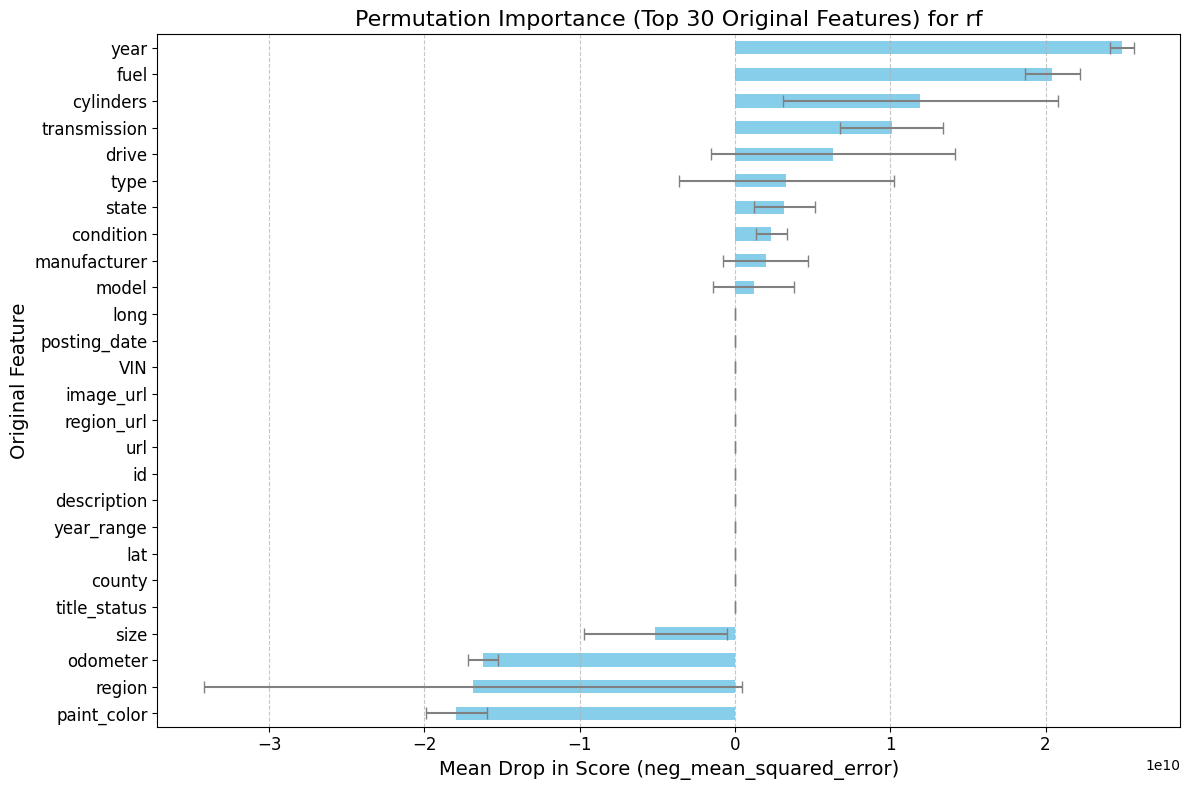

In [33]:
model_to_inspect_name = 'rf' # Or 'rf', etc. Ensure this model was trained successfully

if model_to_inspect_name in best_models and best_models[model_to_inspect_name] is not None:
    fitted_pipeline = best_models[model_to_inspect_name]
    print(f"\nCalculating permutation importance for: {model_to_inspect_name}")

    if not isinstance(X_test, pd.DataFrame):
        raise TypeError("X_test must be a pandas DataFrame for permutation importance with original feature names.")

    original_feature_names = X_test.columns.tolist()
    print(f"Using original features for permutation: {original_feature_names[:5]}... (Total: {len(original_feature_names)})")


    start_time = time.time()
    # Define the scoring metric string you will use
    scoring_metric_for_importance = 'neg_mean_squared_error' # Or 'r2', etc.

    perm_importance_result = permutation_importance(
        estimator=fitted_pipeline,
        X=X_test,
        y=y_test,
        scoring=scoring_metric_for_importance, # Use the defined string
        n_repeats=10, # For real use, 5-10 is common. Lower for quick test.
        random_state=42,
        n_jobs=2
    )
    end_time = time.time()
    print(f"Permutation importance calculation time: {end_time - start_time:.2f} seconds")

    # --- Display Results ---
    importance_means = pd.Series(perm_importance_result.importances_mean, index=original_feature_names)
    importance_stds = pd.Series(perm_importance_result.importances_std, index=original_feature_names)

    sorted_importances = importance_means.sort_values(ascending=False)

    print(f"\nTop 15 Original Features for {model_to_inspect_name} (Permutation Importance on Test Set):")
    print(f"Importance = Mean drop in '{scoring_metric_for_importance}' (a more negative drop / larger positive value if score was positive, means more important).")

    for feature_name in sorted_importances.head(30).index:
        mean_imp = importance_means[feature_name]
        std_imp = importance_stds[feature_name]
        # Ensure feature_name is a string for formatting
        print(f"{str(feature_name):<30} Mean Score Drop: {mean_imp: .4f}  +/- {std_imp: .4f}")

    # --- Corrected Plotting Section ---
    plt.figure(figsize=(12, 8)) # Increased figure size for better readability
    top_n_features = 30
    # Ensure we take top N from sorted_importances for plotting
    plot_importances = sorted_importances.head(top_n_features)
    # Ensure plot_stds corresponds to the order in plot_importances
    plot_stds = importance_stds[plot_importances.index]

    plot_importances.plot(kind='barh', xerr=plot_stds, capsize=4, color='skyblue', ecolor='gray')
    plt.title(f'Permutation Importance (Top {top_n_features} Original Features) for {model_to_inspect_name}', fontsize=16)

    # Use the scoring_metric_for_importance string directly
    plt.xlabel(f'Mean Drop in Score ({scoring_metric_for_importance})', fontsize=14)
    plt.ylabel('Original Feature', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().invert_yaxis() # Display the most important feature at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

elif model_to_inspect_name not in best_models:
    print(f"Model '{model_to_inspect_name}' not found in best_models. Skipping permutation importance.")
else:
    print(f"Model '{model_to_inspect_name}' was not successfully trained (is None). Skipping permutation importance.")


In [30]:
import scipy.stats as stats
print("\n--- Statistical Comparison: ML Models vs. Median Price Baseline ---")
alpha = 0.05 # Significance level

# 1. CALCULATE MEDIAN PRICE BASELINE PREDICTIONS AND ERRORS
median_price_train = df_train['price'].median()
print(f"Median Price from Training Data (Baseline Value): {median_price_train:.2f}")

y_test_arr = np.array(y_test).ravel()
baseline_median_predictions = np.full_like(y_test_arr, fill_value=median_price_train, dtype=float)
baseline_median_abs_errors = np.abs(y_test_arr - baseline_median_predictions)

mae_median_baseline = np.mean(baseline_median_abs_errors)
print(f"MAE of Median Price Baseline on Test Set: {mae_median_baseline:.4f}")

model_abs_errors = {}
# Ensure best_models, X_test, y_test_arr are defined
if 'best_models' in locals() and best_models and 'X_test' in locals() and 'y_test_arr' in locals():
    for name, model in best_models.items():
        if model is None: # Check if model training failed (was set to None)
            print(f"Warning: Model '{name}' is None (likely failed during training). Skipping this model.")
            continue
        try:
            y_pred_arr = np.array(model.predict(X_test)).ravel()
            if len(y_test_arr) == len(y_pred_arr):
                model_abs_errors[name] = np.abs(y_test_arr - y_pred_arr)
            else:
                print(f"Warning: Shape mismatch for {name}. y_test: {len(y_test_arr)}, y_pred: {len(y_pred_arr)}. Skipping this model.")
        except AttributeError: # Handle cases where a "model" might not be a fitted scikit-learn model
             print(f"Warning: Model '{name}' does not have a 'predict' method or is not a valid model. Skipping this model.")
        except Exception as e:
            print(f"Warning: Could not get predictions/errors for {name}: {e}. Skipping this model.")

    # 2. PERFORM STATISTICAL COMPARISONS
    if model_abs_errors:
        statistical_test_results = []
        baseline_model_name_for_reporting = "Median Price Baseline"
        print(f"\nComparing ML models against baseline: '{baseline_model_name_for_reporting}'. Alpha = {alpha}")

        for ml_model_name, current_ml_model_errors in model_abs_errors.items():
            current_ml_model_errors = np.array(current_ml_model_errors)

            if np.isnan(baseline_median_abs_errors).any() or np.isnan(current_ml_model_errors).any():
                print(f"Warning: NaNs found in error arrays for comparison with {ml_model_name}. Skipping tests for this model.")
                statistical_test_results.append({
                    'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                    'T-statistic': np.nan, 'T P-value': np.nan,
                    'Wilcoxon-statistic': np.nan, 'Wilcoxon P-value': np.nan,
                    'Note': 'Skipped due to NaNs in errors'
                })
                continue

            t_statistic, t_p_value = np.nan, np.nan
            w_statistic, w_p_value = np.nan, np.nan

            try:
                t_statistic, t_p_value = stats.ttest_rel(baseline_median_abs_errors, current_ml_model_errors, nan_policy='omit')
            except Exception as e:
                print(f"  T-test failed for {ml_model_name}: {e}")
                pass

            try:
                if np.allclose(baseline_median_abs_errors, current_ml_model_errors):
                    w_p_value = 1.0
                    w_statistic = 0.0
                    print(f"  Wilcoxon: Errors for {ml_model_name} are identical to baseline. p-value set to 1.0.")
                else:
                    diff = baseline_median_abs_errors - current_ml_model_errors
                    if np.allclose(diff, 0):
                         w_p_value = 1.0
                         w_statistic = 0.0
                         print(f"  Wilcoxon: All differences between baseline and {ml_model_name} errors are zero. p-value set to 1.0.")
                    elif len(diff[~np.isnan(diff)]) > 0 and len(np.unique(diff[~np.isnan(diff)])) < 2 :
                         print(f"  Wilcoxon: Not enough distinct differences for {ml_model_name} (all non-NaN diffs are the same or too few samples). Skipping Wilcoxon.")
                    else:
                        w_statistic, w_p_value = stats.wilcoxon(baseline_median_abs_errors, current_ml_model_errors,
                                                              zero_method='pratt', alternative='two-sided',
                                                              nan_policy='omit')
            except ValueError as ve:
                print(f"  Wilcoxon test failed for {ml_model_name}: {ve}. This might be due to too few samples or all differences being zero.")
                pass
            except Exception as e:
                print(f"  Wilcoxon test failed for {ml_model_name} with an unexpected error: {e}")
                pass

            statistical_test_results.append({
                'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                'T-statistic': t_statistic, 'T P-value': t_p_value,
                'Wilcoxon-statistic': w_statistic, 'Wilcoxon P-value': w_p_value
                })

            print(f"\nComparison: {ml_model_name} vs Median Baseline")
            mae_ml_model = np.mean(current_ml_model_errors)
            print(f"  MAE for {ml_model_name}: {mae_ml_model:.4f}")

            t_sig_str = "N/A"
            w_sig_str = "N/A"
            t_conclusion = ""
            w_conclusion = ""

            t_p_value_str = f"{t_p_value:.4f}" if pd.notna(t_p_value) else "N/A"
            w_p_value_str = f"{w_p_value:.4f}" if pd.notna(w_p_value) else "N/A"

            if pd.notna(t_p_value):
                t_sig = t_p_value < alpha
                t_sig_str = "Yes" if t_sig else "No"
                if t_sig:
                    mean_diff = np.nanmean(baseline_median_abs_errors) - np.nanmean(current_ml_model_errors)
                    if mean_diff > 0: t_conclusion = "ML model significantly better (T-test)."
                    elif mean_diff < 0: t_conclusion = "Median Baseline significantly better (T-test)."
                    else: t_conclusion = "No significant difference in means, but p-value < alpha (rare)."

            if pd.notna(w_p_value):
                w_sig = w_p_value < alpha
                w_sig_str = "Yes" if w_sig else "No"
                if w_sig:
                    median_of_differences = np.nanmedian(baseline_median_abs_errors - current_ml_model_errors)
                    if median_of_differences > 0: w_conclusion = "ML model significantly better (Wilcoxon)."
                    elif median_of_differences < 0: w_conclusion = "Median Baseline significantly better (Wilcoxon)."
                    else: w_conclusion = "Median of differences is zero, but p-value < alpha (Wilcoxon)."

            print(f"  T-test: p={t_p_value_str}, Significant: {t_sig_str}. {t_conclusion}")
            print(f"  Wilcoxon: p={w_p_value_str}, Significant: {w_sig_str}. {w_conclusion}")

        if statistical_test_results:
            stat_tests_df = pd.DataFrame(statistical_test_results)
            stat_tests_df['T-test Significant'] = stat_tests_df['T P-value'].apply(
                lambda p: 'Yes' if pd.notna(p) and p < alpha else ('No' if pd.notna(p) else 'Failed/Skipped')
            )
            stat_tests_df['Wilcoxon Significant'] = stat_tests_df['Wilcoxon P-value'].apply(
                lambda p: 'Yes' if pd.notna(p) and p < alpha else ('No' if pd.notna(p) else 'Failed/Skipped')
            )
            print("\n--- Summary of Statistical Test Results (vs Median Price Baseline) ---")

            for col in ['T P-value', 'Wilcoxon P-value']:
                if col in stat_tests_df:
                    stat_tests_df[col] = stat_tests_df[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
            for col in ['T-statistic', 'Wilcoxon-statistic']:
                 if col in stat_tests_df:
                    stat_tests_df[col] = stat_tests_df[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")

            print(stat_tests_df.to_string(index=False))
            try:
                csv_filename = "statistical_test_summary_vs_median_baseline.csv"
                stat_tests_df.to_csv(csv_filename, index=False)
                print(f"\nStatistical test summary saved to {csv_filename}")
            except Exception as e:
                print(f"\nError saving statistical test summary to CSV: {e}")
        else:
            print("\nNo statistical test comparisons were successfully performed.")
    else:
        print("\nNo ML model errors processed for comparison (model_abs_errors dictionary is empty).")
else:
    print("\nError: 'best_models' dictionary not found/empty, or 'X_test'/'y_test_arr' not defined. Cannot perform statistical comparison.")



--- Statistical Comparison: ML Models vs. Median Price Baseline ---
Median Price from Training Data (Baseline Value): 13995.00
MAE of Median Price Baseline on Test Set: 95745.7365

Comparing ML models against baseline: 'Median Price Baseline'. Alpha = 0.05

Comparison: linear_simple vs Median Baseline
  MAE for linear_simple: 166117.3640
  T-test: p=0.0000, Significant: Yes. Median Baseline significantly better (T-test).
  Wilcoxon: p=0.0000, Significant: Yes. Median Baseline significantly better (Wilcoxon).

Comparison: linear_poly vs Median Baseline
  MAE for linear_poly: 331765.4806
  T-test: p=0.0000, Significant: Yes. Median Baseline significantly better (T-test).
  Wilcoxon: p=0.0000, Significant: Yes. Median Baseline significantly better (Wilcoxon).

Comparison: dt vs Median Baseline
  MAE for dt: 126377.2700
  T-test: p=0.0000, Significant: Yes. Median Baseline significantly better (T-test).
  Wilcoxon: p=0.0807, Significant: No. 

Comparison: rf vs Median Baseline
  MAE for r